In [1]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
#import corner
import zeus

import sys
sys.path.append('../kl_tools/')
import getdist
from getdist import plots, MCSamples

from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.io import fits
import astropy.units as u
import astropy.constants as const
#%matplotlib inline

In [2]:
chain_dir = '../tests/test-mcmc-run/hst_g141_noisefree_AEGIS19843-like_smallGal'
fname_sampler = chain_dir+'/test-mcmc-sampler.pkl'
fname_truth = chain_dir+'/test-mcmc-truth.pkl'
fname_runner = chain_dir+'/test-mcmc-runner.pkl'
with open(fname_sampler, 'rb') as f:
    sampler = pickle.load(f)
    
with open(fname_truth, 'rb') as f:
    truth = pickle.load(f)
    
with open(fname_runner, 'rb') as f:
    runner = pickle.load(f)

# Chain Convergence

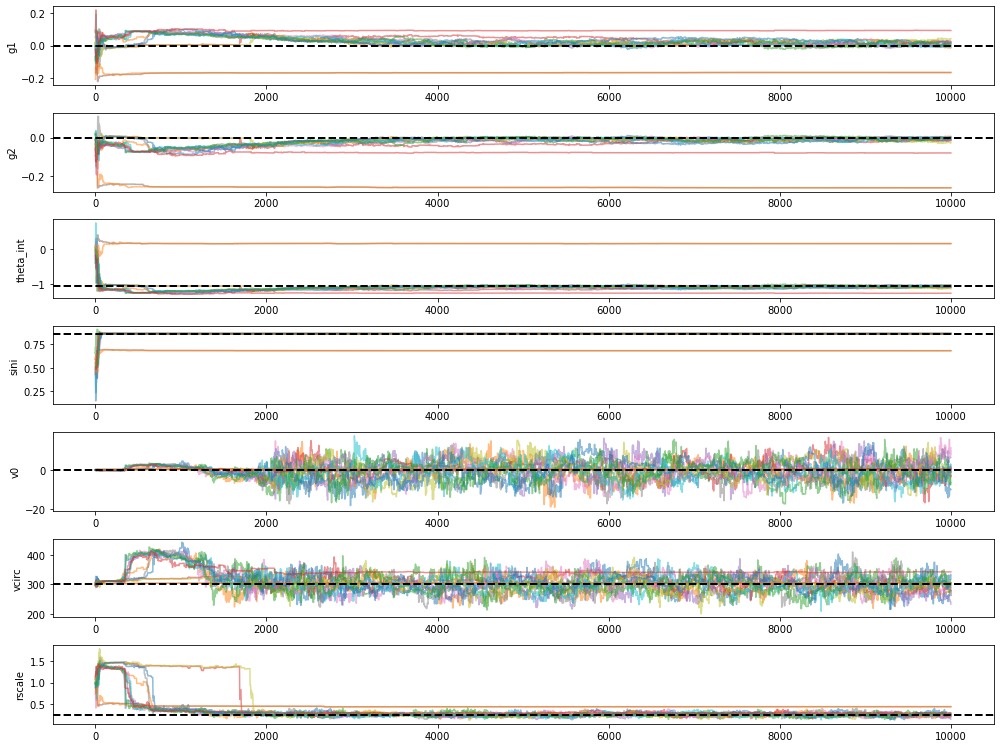

In [3]:
ndim = len(truth)
names = ['g1', 'g2', 'theta_int', 'sini', 'v0', 'vcirc', 'rscale']
labels = [r'g_1', r'g_2', r'\theta_{int}', r'sin(i)', r'v_0', r'v_{circ}', r'r_{scale}']
# truth = [.05, -.1, np.pi/3, 0.75, 1000, 50, 5, 5]

chain = sampler.get_chain()
burn = 0

# scale the units for some things
# chain[:,:,2] *= 180./np.pi # theta_int to degrees

plt.figure(figsize=(2*ndim,1.5*ndim))
for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(chain[burn:,:,n], alpha=0.5)
    plt.axhline(truth[n], lw=2, c='k', ls='--')
    plt.ylabel(names[n])
plt.tight_layout()

In [4]:
for i in range(14):
    print(i,chain[-1][i][2])

0 -1.0627717250707658
1 -1.0148038238744672
2 -1.0741236604654105
3 -1.0925722700956186
4 -1.0696369424453647
5 0.15146886824137082
6 -1.035865002248068
7 -1.077903664855633
8 -1.1275625646844303
9 -1.0236681526725473
10 -1.0417670802074448
11 0.15041712253929918
12 -1.0445280955519813
13 -1.251720099213883


In [15]:
bad_walkers = [5, 11, 13]

# Chain Posterior

In [25]:
Nburn = 3000
Nrest = 10000 - Nburn
n_goodwalkers = 14 - len(bad_walkers)
_chains = sampler.get_chain(flat=False, discard = Nburn)
_blobs = sampler.get_blobs(flat=False, discard = Nburn)
print(_chains.shape)
print(_blobs.shape)

chains = np.zeros((Nrest, n_goodwalkers, 7))
blobs = np.zeros((Nrest, n_goodwalkers, 5))
chains_flat = np.zeros((n_goodwalkers*Nrest, 7))
blobs_flat = np.zeros((n_goodwalkers*Nrest, 5))

_j = 0
for j in range(14):
    if j in bad_walkers:
        continue
    else:
        for i in range(Nrest):
            for k in range(7):
                chains[i][_j][k] = _chains[i][j][k]
                chains_flat[i*n_goodwalkers + _j][k] = _chains[i][j][k]
            for k in range(5):
                blobs[i][_j][k] = _blobs[i][j][k]
                blobs_flat[i*n_goodwalkers + _j][k] = _blobs[i][j][k]
        _j += 1
#chains_flat = chains.reshape((11*5000, 7))
#blobs_flat = blobs.reshape(11*5000, 5)
print(chains_flat.shape)
print(blobs_flat.shape)

(7000, 14, 7)
(7000, 14, 5)
(77000, 7)
(77000, 5)


Removed no burn in


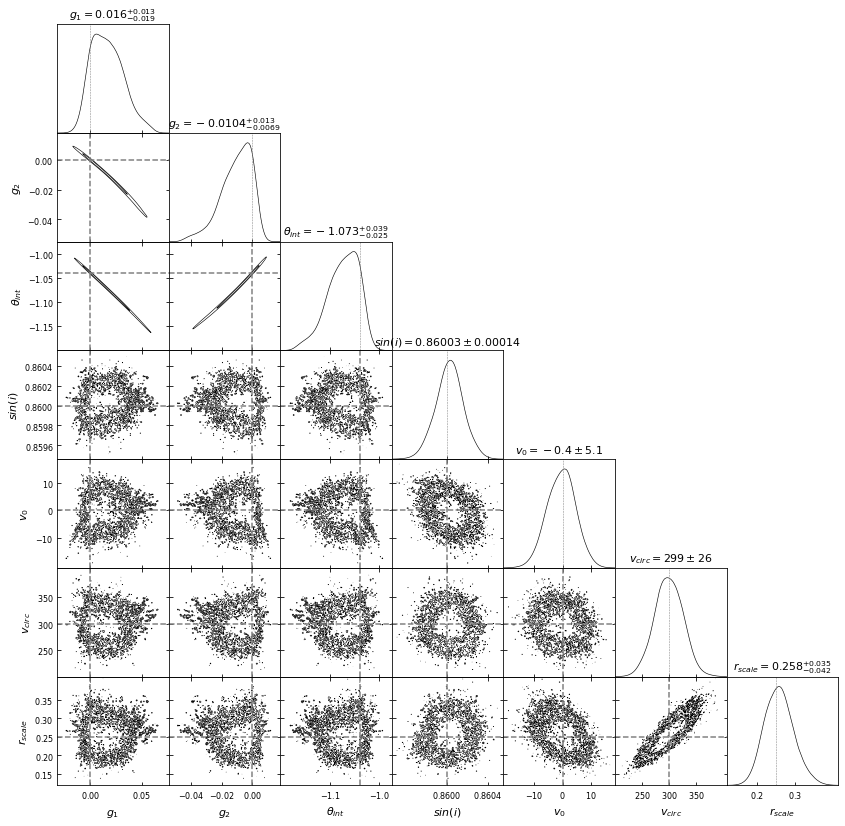

In [27]:
sample_total = getdist.mcsamples.MCSamples(samples=chains_flat, 
                                           names=names, labels=labels,
                                          loglikes=blobs_flat[:,1])

Nsamples = len(chains)
g = plots.get_subplot_plotter()
g.settings.title_limit_fontsize = 14
g.triangle_plot(
    [sample_total],
    filled=False, title_limit=1, color='b',
    markers=truth, 
    marker_args={'lw':1.5,'ls':'--',},
    
)
#plt.show()
plt.savefig('post_small_gal.png', dpi=300)

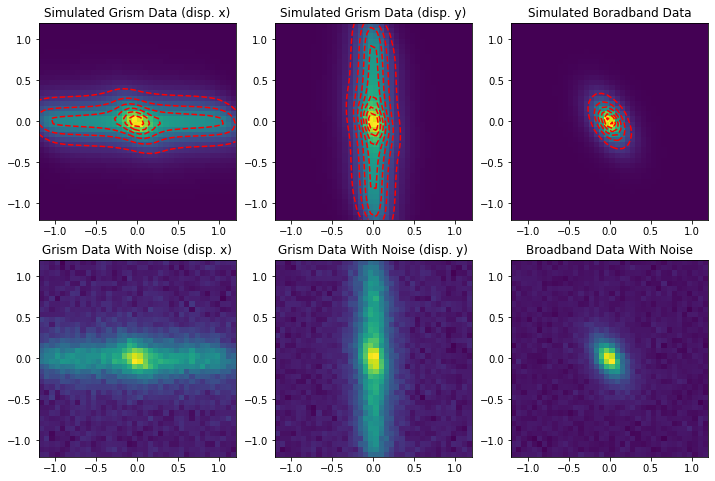

In [22]:
loglike = runner.pfunc.log_likelihood
ds = runner.dsim_ptr
dv = loglike.datavector
noise = loglike.covariance
pars = runner.pars

fig, axes = plt.subplots(2,3, figsize=(12,8))

for i in range(pars.meta['observations']['number_of_observations']):
    _p = pars.meta['observations']['obs_%d'%(i+1)]
    Nx, Ny, scale = _p['Nx'], _p['Ny'], _p['pixel_scale']
    Rx = Nx//2 - 0.5*((Nx-1)%2)
    Ry = Ny//2 - 0.5*((Ny-1)%2)
    x = np.arange(-Rx, Rx+1, 1) * scale
    y = np.arange(-Ry, Ry+1, 1) * scale
    X, Y = np.meshgrid(x, y)
    extent = [x[0], x[-1], y[0], y[-1]]
    
    axes[0,i].imshow(dv[i], extent=extent, origin='lower')
    axes[0,i].contour(X,Y,dv[i], colors='r', 
                      linestyles='dashed'
                     )
    #axes[0,i].contour(np.fliplr(X),Y,dv[i], colors='b', 
    #                 # linestyles='dashed'
    #                 )
    #axes[0,i].contour(X,np.flipud(Y),dv[i], colors='r', 
                     # linestyles='dashed'
    #                 )
    axes[1,i].imshow(dv[i]+noise[i], extent=extent, origin='lower')

axes[0,0].set_title('Simulated Grism Data (disp. x)')
axes[0,1].set_title('Simulated Grism Data (disp. y)')
axes[0,2].set_title('Simulated Boradband Data')
axes[1,0].set_title('Grism Data With Noise (disp. x)')
axes[1,1].set_title('Grism Data With Noise (disp. y)')
axes[1,2].set_title('Broadband Data With Noise')
#plt.show()
plt.savefig('dv_small_gal.png', dpi=300)

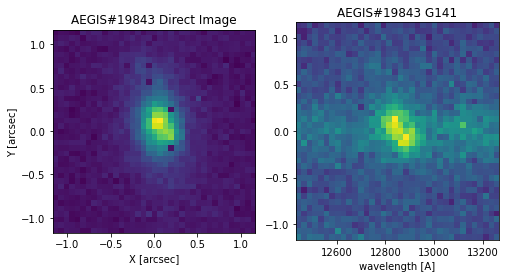

In [19]:
aegis_dir = "/Users/jiachuanxu/Workspace/HST/HST_GRISM_ARCHIVAL_DATA/3D_HST/AEGIS/"
AEGIS_01_19843_2d = fits.open(aegis_dir+"aegis-01/2D/FITS/aegis-01-G141_19843.2D.fits")

#AEGIS_01_19843_2d.info()
fig, axes = plt.subplots(1,2, figsize=(8,4))

dsci = AEGIS_01_19843_2d[2].data
Nx_dsci = AEGIS_01_19843_2d[1].header['NAXIS1']
Ny_dsci = AEGIS_01_19843_2d[1].header['NAXIS2']
Rx_dsci = Nx_dsci//2 - 0.5*((Nx_dsci-1)%2)
Ry_dsci = Ny_dsci//2 - 0.5*((Ny_dsci-1)%2)
scale_dsci = 0.13/2.
x_dsci = np.arange(-Rx_dsci, Rx_dsci+1, 1)*scale_dsci
y_dsci = np.arange(-Ry_dsci, Ry_dsci+1, 1)*scale_dsci
extent_dsci = [x_dsci[0], x_dsci[-1], y_dsci[0], y_dsci[-1]]

axes[0].imshow(dsci, extent=extent_dsci, origin='lower')
axes[0].set(xlabel='X [arcsec]', ylabel='Y [arcsec]')

sci = AEGIS_01_19843_2d[5].data
wave = AEGIS_01_19843_2d[9].data
extent_2dsci = [wave[0], wave[-1], x_dsci[0], x_dsci[-1]]
axes[1].imshow(sci, extent=extent_2dsci, aspect='auto', origin='lower'
              )
axes[1].set(xlabel='wavelength [A]')
axes[1].set_xlim([12850-18*AEGIS_01_19843_2d[5].header['CD1_1'],
          12850+18*AEGIS_01_19843_2d[5].header['CD1_1']])

axes[0].set_title('AEGIS#19843 Direct Image')
axes[1].set_title('AEGIS#19843 G141')
plt.show()
#plt.savefig('aegis#19843.png', dpi=300)

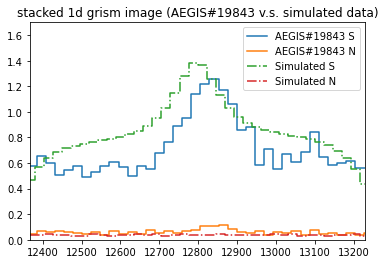

In [21]:
mdl = AEGIS_01_19843_2d[7].data
nsy = np.sqrt(np.sum((sci-mdl)**2, axis=0))

plt.plot(wave, np.sum(sci, axis=0), drawstyle='steps-mid', label='AEGIS#19843 S')
plt.plot(wave, nsy, drawstyle='steps-mid', label='AEGIS#19843 N')

w = (np.arange(-19,19,1) + 550.96322)*46.5/2
plt.plot(w, np.sum(dv[0]/5000, axis=0), drawstyle='steps-mid', label='Simulated S', ls='-.')
plt.plot(w, np.sqrt(np.sum((noise[0]/5000)**2, axis=0)), drawstyle='steps-mid', label='Simulated N', ls='-.')

plt.xlim([w[0], w[-1]])
plt.ylim([0,1.7])
plt.legend()
plt.title('stacked 1d grism image (AEGIS#19843 v.s. simulated data)')
#plt.show()
plt.savefig('stacked_2d_grism_small_gal.png', dpi=300)

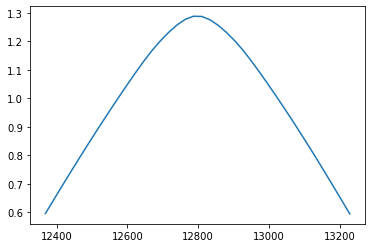

In [149]:
AEGIS_01_19843_2d.info()

Filename: /Users/jiachuanxu/Workspace/HST/HST_GRISM_ARCHIVAL_DATA/3D_HST/AEGIS/aegis-01/2D/FITS/aegis-01-G141_19843.2D.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   ()      
  1  DSCI          1 ImageHDU         8   (37, 37)   float64   
  2  DINTER        1 ImageHDU         8   (37, 37)   float64   
  3  DWHT          1 ImageHDU         8   (37, 37)   float32   
  4  DSEG          1 ImageHDU         8   (37, 37)   int32   
  5  SCI           1 ImageHDU        21   (312, 37)   float64   
  6  WHT           1 ImageHDU        22   (312, 37)   float64   
  7  MODEL         1 ImageHDU        22   (312, 37)   float64   
  8  CONTAM        1 ImageHDU        22   (312, 37)   float64   
  9  WAVE          1 ImageHDU        21   (312,)   float64   
 10  SENS          1 ImageHDU        22   (312,)   float64   
 11  YTRACE        1 ImageHDU        22   (312,)   float64   


(12432.441634452396, 13267.558365547604)

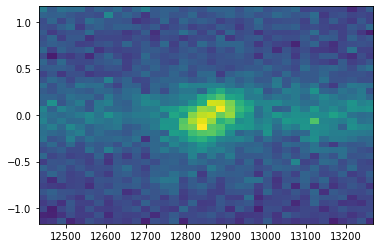

In [137]:
#fig, axes = plt.subplots(2,1,figsize=(2,4))


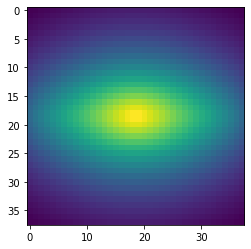

In [156]:

plt.imshow(dv[0])

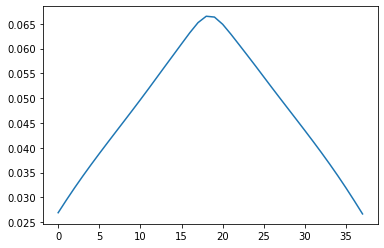

In [162]:
plt.plot(dv[0][19,:]/5000)